# Importación de librerias

In [1]:
#Librerias utilizadas en el trabajo de datos y predicción
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sbn
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Flatten
from datetime import timedelta
from pptx.util import Inches
from pptx import Presentation

# Importación de dataset

In [2]:
#Importacion del dataset que contiene los computadores, con precio, id, tienda y fecha
df = pd.read_excel("precioFechaPorId.xlsx")#, index_col=9, parse_dates=True#)

In [3]:
#Eliminación de columna Unnamed: 0 que se crea al importar el xlsx
try:
    df = df.drop({"Unnamed: 0"}, axis=1)
except:
    x=2

In [4]:
df = df.drop_duplicates(["ID_SKU", "FECHA", "TIENDA"], keep='first')

# Creación de funciones de validacion para el id_sku y la tienda del producto

In [5]:
#Función que retorna las tiendas que pertenecen a un sku en especifico
def BuscarTiendas(id):
    final = df[df["ID_SKU"]== id]
    tiendas = final.groupby(["TIENDA"]).count().index
    return tiendas

In [6]:
#Función para poder validar las tiendas en las que se encuentra el producto
def ValidarTiendas(tiendas):
    print("Las tiendas disponibles para este producto son: ")
    for i in range(len(tiendas)):
        print(tiendas[i])
    return "Elija una de ellas"


In [7]:
#Función que permite verificar si la tienda ingresada es valida
def VerificarTiendas(tienda, tiendas):
    aux = []
    for i in range(len(tiendas)):
        aux.append(tiendas[i])

    for i in range(len(aux)):
        if(aux[i] == tienda):
            return "Tienda agregada correctamente"
    return "ERROR"


In [8]:
#Función que realiza el filtro de productos en relación al id y la tienda del mismo
def buscarElemento(id, tienda):
    final = df[df["ID_SKU"]== id]
    final = final[final["TIENDA"]== tienda]     
    return final


In [9]:
#Función que realiza la buqueda del producto de forma concreta
def buscarProducto():
    i = int(input("Ingrese id_sku del producto: "))
    tiendas = BuscarTiendas(i)
    ValidarTiendas(tiendas)
    error = 0
    while(error == 0):
        j = input("Ingrese tienda que desee trabajar \n").upper()
        y = VerificarTiendas(j, tiendas)
        if (y =="ERROR"):
            print("Tienda equivocada, ingrese nuevamente")

        else:
            error = 1
    producto = buscarElemento(i,j)
    return producto
    

# Filtro del producto aplicando funciones creadas previamente

In [10]:
#Segmento de codigo en el que permite ver si la cantidad de registros permitirá la predicción de 7 dias, sino se reinicia el ciclo
aux = 0
while(aux == 0):
    producto = buscarProducto()
    if(len(producto)>=14):
        aux = 1
    else:
        print("La cantidad de registros del producto es menor a lo ideal, ingrese otro producto")

Las tiendas disponibles para este producto son: 
HITES
PC FACTORY
RIPLEY


In [11]:
#Reinicio del indice del dataset despues de ser filtrado
producto.reset_index(inplace=True, drop=False)
producto = producto.drop(["index"], axis=1)

In [12]:
#Muestra del filtrado de producto
producto

,ID_SKU,PRECIO,FECHA,TIENDA
0,8,269990,2021-11-30,HITES
1,8,269990,2021-12-01,HITES
2,8,269990,2021-12-02,HITES
3,8,269990,2021-12-03,HITES
4,8,269990,2021-12-04,HITES
5,8,269990,2021-12-05,HITES
6,8,269990,2021-12-06,HITES
7,8,269990,2021-12-07,HITES
8,8,269990,2021-12-08,HITES
9,8,269990,2021-12-09,HITES


# Visualizacion de precios en relación a la fecha

<AxesSubplot:xlabel='FECHA'>

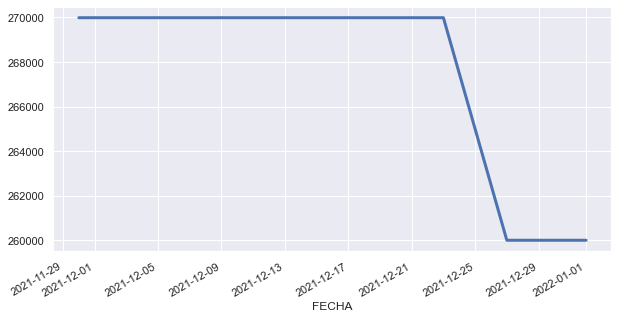

In [13]:
#Generacion del grafico con plot en realcion a la fecha y precio
sbn.set(rc={'figure.figsize':(10, 5)})
filtrado = producto[["FECHA", "PRECIO"]]
filtrado.index = filtrado['FECHA']
filtrado['PRECIO'].plot(linewidth = 3.0)

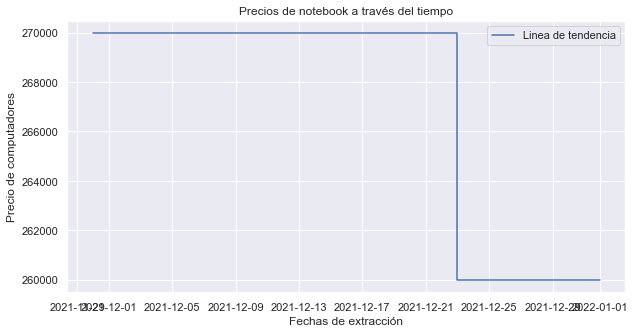

In [14]:
#Generación del grafico de tendencia del precio en relación a la fecha
x = filtrado["FECHA"]
y = filtrado["PRECIO"]

plt.step(x,y)


plt.xlabel('Fechas de extracción')
plt.ylabel('Precio de computadores')
plt.title('Precios de notebook a través del tiempo')
plt.legend(['Linea de tendencia'])

# save the figure
plt.savefig('TendenciaAntes.png', dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.savefig('TendenciaAntes.jpg', dpi=300, bbox_inches='tight', pad_inches=0.1)


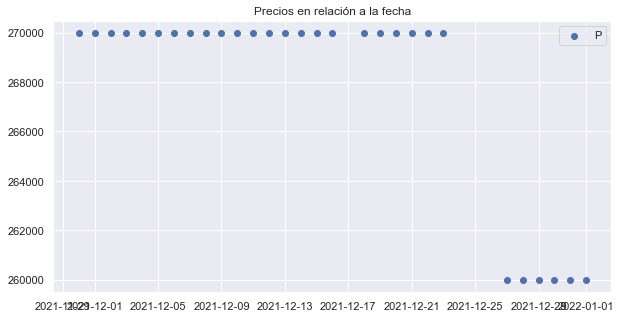

In [15]:
#Generación de grafico de puntos
plt.scatter(filtrado["FECHA"], filtrado["PRECIO"])
plt.title("Precios en relación a la fecha")
plt.legend("Precios")
plt.savefig('scatterAntes.png', dpi=300, bbox_inches='tight')
plt.savefig('scatterAntes.jpg', dpi=300, bbox_inches='tight')

In [16]:
# Convertir series en aprendizaje supervisado
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [17]:
precios = filtrado['PRECIO'].values
precios = precios.astype('float32')

# Normalización de caracteristicas
scaler = MinMaxScaler(feature_range=(-1, 1))
precios = precios.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(precios)
scaled

array([[ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [ 1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.],
       [-1.]], dtype=float32)

In [18]:
#Definición de los datos de entrenamiento en relación al tamaño del dataset por los registros del producto

PASOS = 7
reframed = series_to_supervised(scaled, PASOS, 1)

if(len(producto)<=20):
    # split into train and test sets
    values = reframed.values
    n_train_days = 4
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)


if(len(producto)>20):
    # split into train and test sets
    values = reframed.values
    n_train_days = int(len(producto) - PASOS*2)
    train = values[:n_train_days, :]
    test = values[n_train_days:, :]
    # split into input and outputs
    x_train, y_train = train[:, :-1], train[:, -1]
    x_val, y_val = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
    x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))
    print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

(15, 1, 7) (15,) (7, 1, 7) (7,)


In [19]:
#Funcion que permite crear el modelo
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(PASOS, input_shape=(1,PASOS),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [20]:
#Entrenamiento de los datos
EPOCHS=40
model = crear_modeloFF()
history=model.fit(x_train,y_train,epochs=EPOCHS,validation_data=(x_val,y_val),batch_size=PASOS)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1, 7)              56        
_________________________________________________________________
flatten (Flatten)            (None, 7)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Epoch 1/40
3/3 [==============================] - 3s 821ms/step - loss: 0.7893 - mse: 0.6230 - val_loss: 1.2714 - val_mse: 1.6734
Epoch 2/40
3/3 [==============================] - 0s 17ms/step - loss: 0.7781 - mse: 0.6055 - val_loss: 1.2729 - val_mse: 1.6785
Epoch 3/40
3/3 [==============================] - 0s 16ms/step - loss: 0.7664 - mse: 0.5874 - val_loss: 1.2743 - val_mse: 1.6833
Ep

In [21]:
train

array([[1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.],
       [1., 1., 1., 1., 1., 1., 1., 1.]], dtype=float32)

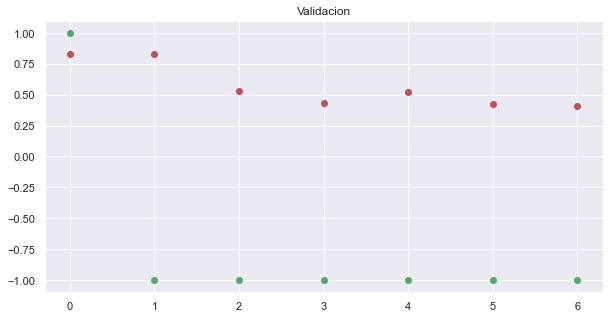

In [22]:
#Correlación entre variables
results=model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('Validacion')
plt.show()

In [23]:
valores = model.predict(x_val)
MinMaxScaler.inverse_transform(scaler, valores)

array([[269122.47],
       [269122.47],
       [267652.56],
       [267134.53],
       [267603.94],
       [267127.97],
       [267044.22]], dtype=float32)

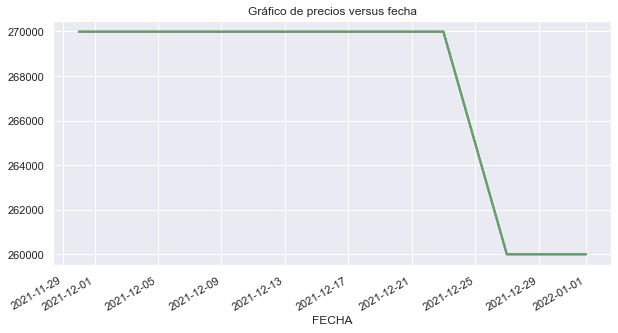

In [24]:
filtrado["PRECIO"].plot(linewidth = 2.0).set_title("Gráfico de precios versus fecha")
filtrado['PRECIO'].plot(linewidth = 2.0).get_figure().savefig("graficoAntes.jpg")
filtrado['PRECIO'].plot(linewidth = 2.0).get_figure().savefig("graficoAntes.png")

In [25]:
#Inserción de datos para contraste  

fecha = producto["FECHA"]
aux = MinMaxScaler.inverse_transform(scaler, valores)
precio = producto["PRECIO"]
id_sku = producto["ID_SKU"][0]
tienda = producto["TIENDA"][0]

nuevosDatos = pd.DataFrame(columns=['ID', 'PRECIO', 'FECHA', 'TIENDA'])

pos = len(fecha) -1
fecha_aux = fecha[pos]

for i in range(len(fecha)):
    nuevosDatos = nuevosDatos.append({"ID":id_sku, "PRECIO": precio[i], "FECHA":fecha[i], "TIENDA":tienda}, ignore_index=True)
    
for i in range(len(aux)):
    fecha_aux2 = fecha_aux + timedelta(i+1)
    nuevosDatos = nuevosDatos.append({"ID":id_sku, "PRECIO":int(aux[i]), "FECHA":fecha_aux2, "TIENDA":tienda }, ignore_index=True)

# Visualización de nuevos datos

In [26]:
#Cambio de indice de dataset del producto filtrado
sbn.set(rc={'figure.figsize':(10, 5)})
filtrado = nuevosDatos[["FECHA", "PRECIO"]]
filtrado.index = filtrado['FECHA']

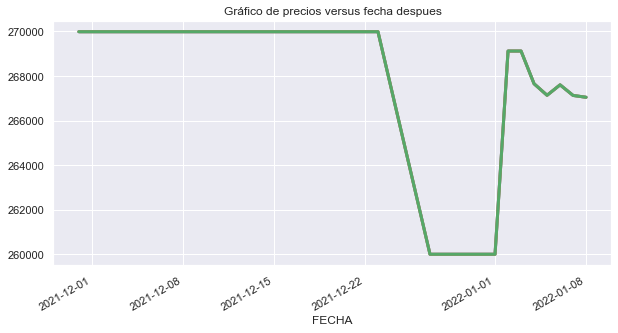

In [27]:
#Generación y exportación de grafico con los valores de los precios del producto
filtrado['PRECIO'].plot(linewidth = 3.0).set_title("Gráfico de precios versus fecha despues")
filtrado['PRECIO'].plot(linewidth = 3.0).get_figure().savefig("graficoDespues.jpg")
filtrado['PRECIO'].plot(linewidth = 3.0).get_figure().savefig("graficoDespues.png")

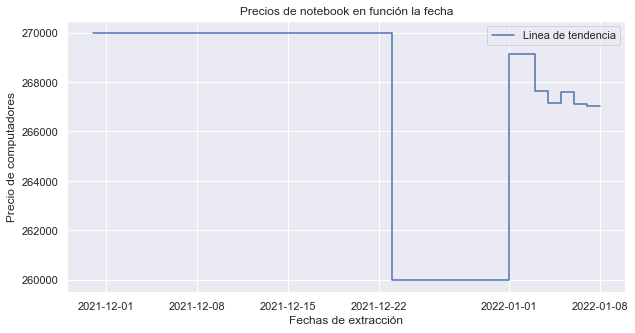

In [28]:
#Creación grafico de tendencia
x = filtrado["FECHA"]
y = filtrado["PRECIO"]
plt.step(x,y)
plt.xlabel('Fechas de extracción')
plt.ylabel('Precio de computadores')
plt.title('Precios de notebook en función la fecha')
plt.legend(['Linea de tendencia'])
plt.savefig('TendenciaDespues.png', dpi=300, bbox_inches='tight')
plt.savefig('TendenciaDespues.jpg', dpi=300, bbox_inches='tight')

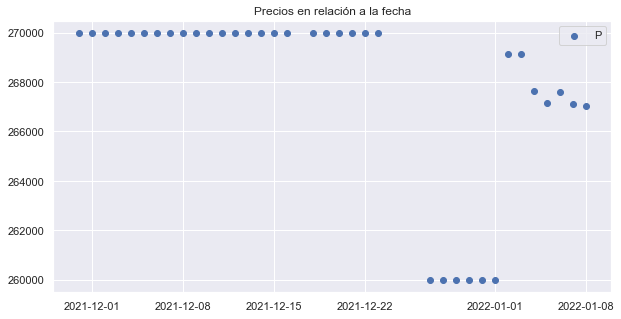

In [29]:
#Generación de grafico de puntos
plt.scatter(filtrado["FECHA"], filtrado["PRECIO"])
plt.title("Precios en relación a la fecha")
plt.legend("Precios")
plt.savefig('scatterDespues.png', dpi=300, bbox_inches='tight')
plt.savefig('scatterDespues.jpg', dpi=300, bbox_inches='tight')

In [30]:
##Creación de Slide que muestra el grafico de precios en relación de la fecha original
from pptx.util import Inches

img_path = "graficoAntes.jpg"

prs = Presentation('test.pptx')
slide = prs.slides.add_slide(prs.slide_layouts[8])
title = slide.shapes.title
title.text="Gráfico de precios antes de la predicción"
left = Inches(2)
top = Inches(2.5)
right = Inches(3.5)
height = Inches(3.5)
pic = slide.shapes.add_picture(img_path, left, top, height=right)


In [31]:
##Creación de slide que muestra el grafico de tendencia de los precios en relación a la fecha con los precios obtenidos por la prediccion.
img_path = "TendenciaAntes.jpg"
slide = prs.slides.add_slide(prs.slide_layouts[8])
title = slide.shapes.title
title.text="Gráfico de tendencia antes de la predicción"
left = Inches(2)
top = Inches(2.5)
right = Inches(3.5)
height = Inches(3.5)
pic = slide.shapes.add_picture(img_path, left, top, height=right)

In [32]:
##Creación de slide que muestra el grafico de tendencia de los precios en relación a la fecha con los precios obtenidos por la prediccion.
img_path = "scatterAntes.jpg"
slide = prs.slides.add_slide(prs.slide_layouts[8])
title = slide.shapes.title
title.text="Muestra de distribución de valores antes"
left = Inches(2)
top = Inches(2.5)
right = Inches(3.5)
height = Inches(3.5)
pic = slide.shapes.add_picture(img_path, left, top, height=right)

In [33]:
##Creación de slide que muestra el grafico de precios en relación a la fecha con los precios obtenidos por la prediccion.
img_path = "graficoDespues.jpg"
slide = prs.slides.add_slide(prs.slide_layouts[8])
title = slide.shapes.title
title.text="Gráfico de precios despues de la predicción"
left = Inches(2)
top = Inches(2.5)
right = Inches(3.5)
height = Inches(3.5)
pic = slide.shapes.add_picture(img_path, left, top, height=right)

In [34]:
##Creación de slide que muestra el grafico de precios en relación a la fecha con los precios obtenidos por la prediccion.
img_path = "TendenciaDespues.jpg"
slide = prs.slides.add_slide(prs.slide_layouts[8])
title = slide.shapes.title
title.text="Gráfico de tendencia despues de la predicción"
left = Inches(2)
top = Inches(2.5)
right = Inches(3.5)
height = Inches(3.5)
pic = slide.shapes.add_picture(img_path, left, top, height=right)

In [35]:
##Creación de slide que muestra el grafico de tendencia de los precios en relación a la fecha con los precios obtenidos por la prediccion.
img_path = "scatterDespues.jpg"
slide = prs.slides.add_slide(prs.slide_layouts[8])
title = slide.shapes.title
title.text="Muestra de distribución de valores después"
left = Inches(2)
top = Inches(2.5)
right = Inches(3.5)
height = Inches(3.5)
pic = slide.shapes.add_picture(img_path, left, top, height=right)

prs.save("PresentacionFinal.pptx")